# Problem Statement


# Table of Contents

### Data Dictionary

### Imports

In [1]:
! pip install pyLDAvis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import scipy
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

from gensim import matutils
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

#### Read In the Data

In [3]:
listing = pd.read_csv('./data/Santa_Cruz_Listings_Clean')
review = pd.read_csv('./data/Santa_Cruz_Reviews_Clean')

#### Allowing up to 100 columns to be previewed

In [4]:
pd.set_option("display.max_columns", 100)

# Feature Engineering

In [5]:
listing.head(3)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bathrooms_text,bedrooms,amenities,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,11879,Sunny room close to beach and parks,Sunny room in a cozy home with a 40 acre park ...,No Content,2009-10-09,"Easygoing, environmentalist, musician/educator...",within a few hours,0.69,4,Unincorporated Areas,36.98186,-121.88114,Private room in house,2,1 shared bath,1.0,"[""Extra pillows and blankets"", ""Free street pa...",$75.00,2,30,60,2010-08-11,2021-02-24,97.0,10.0,9.0,10.0,10.0,10.0,10.0,f,0.47
1,24548,Room with Private Entrance.,Bedroom and bath with private entrance in home...,Great location close to Santa Cruz Harbor and ...,2010-03-26,Easy going and friendly I like to think.\r\n\r...,within an hour,0.93,1,City of Santa Cruz,36.97167,-121.99774,Private room in house,2,1 private bath,1.0,"[""Dedicated workspace"", ""Carbon monoxide alarm...",$100.00,2,5,479,2010-04-24,2020-11-23,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,3.63
2,31721,Dog Friendly Private Pleasure Point Beach Cottage,*LOCATION LOCATION LOCATION* <br />Welcome to ...,I love everything about this neighborhood. I ...,2010-06-01,Hey Airbnb folks thanks for taking the time to...,within a few hours,0.75,2,City of Capitola,36.95849,-121.97207,Entire cottage,3,1 bath,1.0,"[""Dedicated workspace"", ""Carbon monoxide alarm...",$179.00,4,90,222,2012-11-26,2021-01-31,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,2.21


Binarize the columns in order to use data for EDA.

In [6]:
listing['instant_bookable'] = listing['instant_bookable'].map({'f': 0, 't': 1})

Unpacking the list in the 'amenities' column and create dummy columns for each item in the amenities list.

In [7]:
listing['amenities'] = listing['amenities'].map(lambda x: ast.literal_eval(x))

listing = pd.concat([listing, pd.get_dummies(listing['amenities'].apply(pd.Series).stack()).sum(level=0)], axis=1)

In [8]:
listing.drop(columns = ['amenities'], inplace = True)

Creating new columns that provide the character length of the following columns: 'host_about', 'name', 'description', 'neighborhood_overview'.

In [9]:
listing['host_about_length'] = listing['host_about'].str.len()
listing['listing_name_length'] = listing['name'].str.len()
listing['description_length'] = listing['description'].str.len()
listing['neighborhood_overview_length'] = listing['neighborhood_overview'].str.len()

Creating new columns from the values of other columns.

In [10]:
listing = pd.concat([listing, pd.get_dummies(listing['property_type'])], axis = 1)

In [11]:
listing = pd.concat([listing, pd.get_dummies(listing['bathrooms_text'])], axis = 1)

In [12]:
listing.drop(columns = ['property_type', 'bathrooms_text'], inplace = True)

Removing special characters from the price column and then converting from a string to an int.

In [13]:
listing['price'] = listing['price'].map(lambda x: x.lstrip('$'))

In [14]:
listing['price'] = listing['price'].map(lambda x: x.lstrip(','))

In [15]:
listing['price'].dtype

dtype('O')

In [16]:
listing['price'] = listing['price'].map(lambda x: x.split('.')[0])

In [17]:
listing['price'] = listing['price'].str.replace(',','').astype(int)

In [18]:
listing['price'].dtype

dtype('int64')

# Exploratory Data Analysis

In [19]:
listing.head(3)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,2 burner induction stove top induction stove,"30"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Netflix","32"" TV with Amazon Prime Video, Netflix","40"" HDTV","42"" HDTV with Amazon Prime Video, Netflix, HBO Max","42"" HDTV with Netflix","46"" TV with Roku","48"" HDTV with standard cable","50"" HDTV","55"" HDTV with Netflix, HBO Max, Amazon Prime Video, Apple TV","55"" HDTV with premium cable, standard cable, Chromecast, Amazon Prime Video, Netflix, Roku",Air conditioning,Alaffia body soap,Alaffia conditioner,Alaffia shampoo,Alexa Bluetooth sound system,BBQ grill,Baby bath,Baby monitor,...,Private room in barn,Private room in bed and breakfast,Private room in bungalow,Private room in cabin,Private room in camper/rv,Private room in condominium,Private room in dome house,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in house,Private room in loft,Private room in nature lodge,Private room in resort,Private room in tent,Private room in tiny house,Private room in townhouse,Room in boutique hotel,Room in hotel,Shared room in house,Tent,Tiny house,Treehouse,Windmill,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,10 baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5.5 baths,6 baths,6.5 baths,8 baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath
0,11879,Sunny room close to beach and parks,Sunny room in a cozy home with a 40 acre park ...,No Content,2009-10-09,"Easygoing, environmentalist, musician/educator...",within a few hours,0.69,4,Unincorporated Areas,36.98186,-121.88114,2,1.0,75,2,30,60,2010-08-11,2021-02-24,97.0,10.0,9.0,10.0,10.0,10.0,10.0,0,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,24548,Room with Private Entrance.,Bedroom and bath with private entrance in home...,Great location close to Santa Cruz Harbor and ...,2010-03-26,Easy going and friendly I like to think.\r\n\r...,within an hour,0.93,1,City of Santa Cruz,36.97167,-121.99774,2,1.0,100,2,5,479,2010-04-24,2020-11-23,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,3.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31721,Dog Friendly Private Pleasure Point Beach Cottage,*LOCATION LOCATION LOCATION* <br />Welcome to ...,I love everything about this neighborhood. I ...,2010-06-01,Hey Airbnb folks thanks for taking the time to...,within a few hours,0.75,2,City of Capitola,36.95849,-121.97207,3,1.0,179,4,90,222,2012-11-26,2021-01-31,95.0,10.0,9.0,10.0,10.0,10.0,9.0,0,2.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


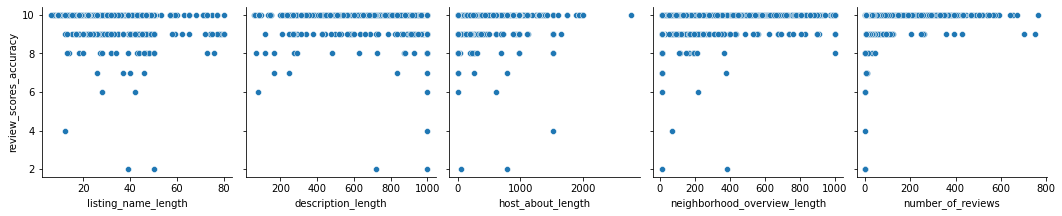

In [20]:
sns.pairplot(listing, 
             x_vars = ['listing_name_length', 'description_length', 'host_about_length', 'neighborhood_overview_length', 'number_of_reviews'], 
             y_vars = ['review_scores_accuracy'], 
             diag_kind = None, 
             height = 3);

look at what amenities have the highest correlations to the high scored reviews 

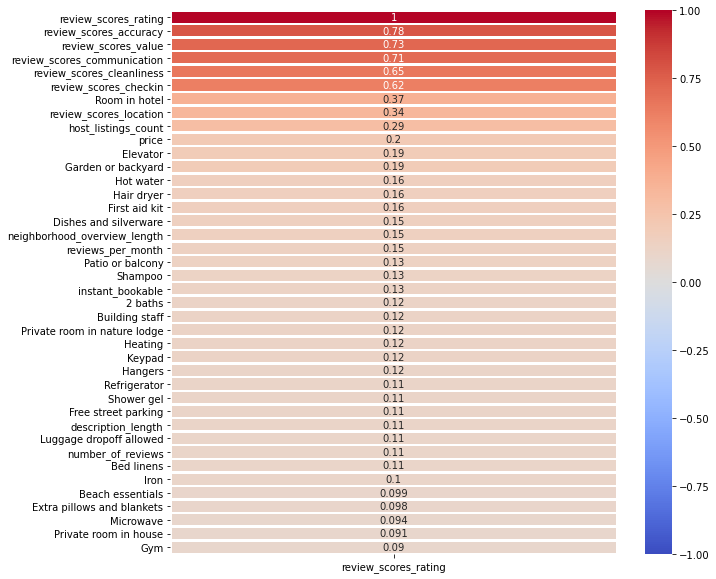

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['review_scores_rating']].abs().sort_values(by = ['review_scores_rating'], ascending = False)

sns.heatmap(corrs.head(40),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

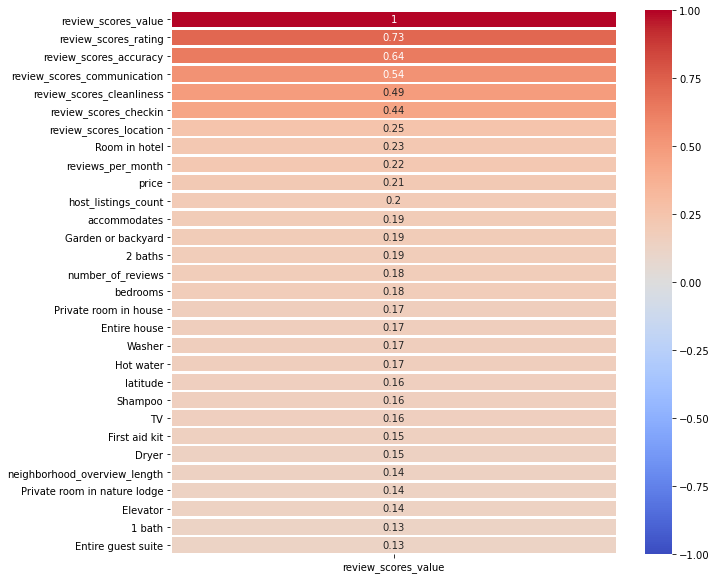

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['review_scores_value']].abs().sort_values(by = ['review_scores_value'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

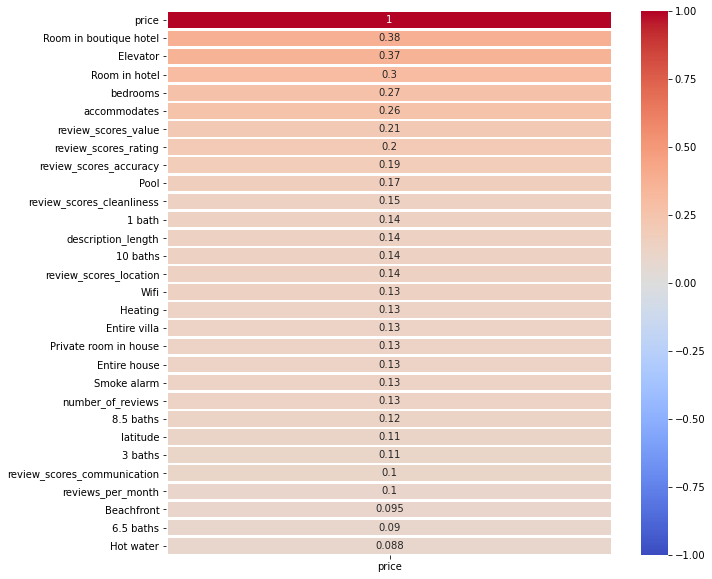

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['price']].abs().sort_values(by = ['price'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

## Sentiment Analysis

In [24]:
pd.options.display.max_colwidth = 200

In [25]:
corpus = list(review['comments']) 

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
sentiment = []    

for comment in corpus:
    scores = sia.polarity_scores(comment)
    scores['comment'] = comment
    sentiment.append(scores)

reviews = pd.DataFrame(sentiment)
reviews.head()

,neg,neu,pos,compound,comment
0,0.0,0.736,0.264,0.9733,"If you're staying in Aptos, Steve's house is in a great spot. We used the Polo grounds every day, and explored the redwoods behind them for some more action. There are plenty of food spots and res..."
1,0.0,0.384,0.616,0.9702,"Sunny room was perfect for my needs. Relaxed and comfortable house, beautiful location. Steven was friendly. I would gladly stay there again."
2,0.0,0.670,0.330,0.9690,"Steven's home is comfortable and welcoming. I could not have felt more at home than I did during my stay there. He is an amazing and friendly host, and I happily and heartily recommend him and hi..."
3,0.0,0.580,0.420,0.9837,Steve is a very thoughtful host. He is a peaceful and zen person and genuinely cares and caters to peoples needs. His place is very peaceful and has a nice positive feel. He is generous and shares...
4,0.0,0.586,0.414,0.9545,"Steven was very welcoming, laid back, gave me a great breakfast location tip and it is a cool place to relax as well as a very short drive to all the beauty of the area."


In [28]:
reviews['id'] = review['listing_id']

In [29]:
reviews.sort_values(by = 'pos', ascending = False).head(10)

,neg,neu,pos,compound,comment,id
25024,0.0,0.098,0.902,0.9611,Great place! Super clean! Great view! Recommend!,22971435
9073,0.0,0.103,0.897,0.9551,Amazing and relaxing place! Super comfortable :),7114567
28633,0.0,0.104,0.896,0.8225,Clean - well decorated - charming.,28720801
24801,0.0,0.110,0.890,0.9533,GREAT location! GREAT value!! Very Clean!,22869390
24924,0.0,0.116,0.884,0.9449,Beautiful home! Great location & super clean!,22928324
7957,0.0,0.120,0.880,0.9393,Great townhouse. Super location. Super clean.,6285260
23119,0.0,0.122,0.878,0.9371,Great location. Super clean. Excellent communication.,21679110
7551,0.0,0.125,0.875,0.9324,Loved it! Super cute decor. Safe.,6004171
13836,0.0,0.127,0.873,0.9300,"Friendly host, great location, great value.",12915176
2754,0.0,0.140,0.860,0.9612,"Charming space, lovely hosts, great location, great value!",1649986


In [30]:
reviews.sort_values(by = 'neg', ascending = False).head(10)

,neg,neu,pos,compound,comment,id
17343,0.495,0.505,0.000,-0.5994,No complaints from the five of us.,16423067
16693,0.415,0.585,0.000,-0.5504,As described. Not luxurious but comfortable.,15856862
10434,0.390,0.610,0.000,-0.8625,This place was disgusting- we had to buy pillows because bedding was gross. The lock box was broken.,8306184
6791,0.377,0.308,0.315,0.0516,Awesome location. Dope hot tub. No complaints.,5395988
15848,0.370,0.630,0.000,-0.4471,The surrounding is not so nice,14727746
25596,0.362,0.315,0.323,-0.1260,Awesome location with a killer hot tub!,23590261
18620,0.361,0.525,0.114,-0.8560,Very nice little deck - beautiful trees - the space is a bit strange in layout - not super comfortable but the bed is very comfortable! Feels a bit neglected in upkeep.,17814562
13590,0.359,0.641,0.000,-0.4215,Off the beaten path in redwoods.,12541473
29775,0.358,0.642,0.000,-0.5365,Incredible view. Not sure how you could complain staying there.,31711091
5976,0.351,0.460,0.189,-0.4886,Wonderful treehouse with VERY RUDE neighbors who won't like you staying there.,4950937


In [31]:
reviews.sort_values(by = 'pos', ascending = True).head(10)

,neg,neu,pos,compound,comment,id
9167,0.000,1.000,0.0,0.0000,I can't do this because I was not there.,7265782
11007,0.248,0.752,0.0,-0.6818,horrible communication. would never recommend this place to anyone. shouldn't even be allowed on Airbnb. still haven't received a response.,8742182
11013,0.000,1.000,0.0,0.0000,"Cozy, unique location, with a very personable host.",8742182
21549,0.000,1.000,0.0,0.0000,a large property with a very personal feel and experience,19987478
16929,0.000,1.000,0.0,0.0000,I do not write public reviews.,16042569
28696,0.162,0.838,0.0,-0.5093,We saw a turkey vulture spread swoop down right in front of the porch. Lots of hummingbird watching too!,28762913
2480,0.000,1.000,0.0,0.0000,"Close to everything in Santa Cruz, very walkable!",1426294
5314,0.000,1.000,0.0,0.0000,Very quite setting . Plenty of room for the family . Directions in were spot on.,3850140
13046,0.000,1.000,0.0,0.0000,"The place is bigger than we expected and very, very quiet (just what we were looking for).",12018171
9463,0.000,1.000,0.0,0.0000,the sleeping space in the loft is tight for tall people.,7474325


Aggregating at the ID level taking the mean per column and then merging the dataframes.

In [32]:
reviews_agg = reviews.groupby('id', as_index=False)['pos', 'neu', 'neg', 'compound'].mean()

In [33]:
listing_reviews = listing.merge(reviews_agg, on = 'id')

In [34]:
listing_reviews.shape

(858, 341)

In [35]:
listing_reviews.isnull().sum().sum()

0

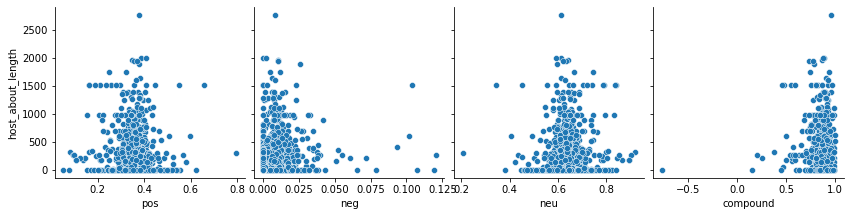

In [36]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['host_about_length'], 
             diag_kind = None, 
             height = 3);

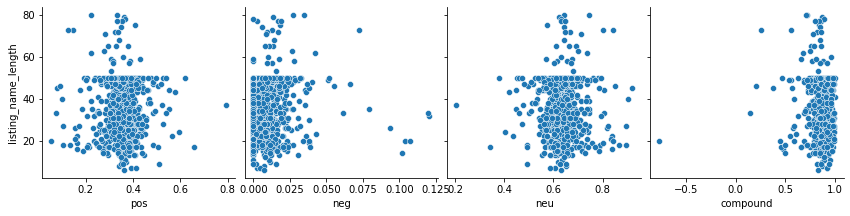

In [37]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['listing_name_length'], 
             diag_kind = None, 
             height = 3);

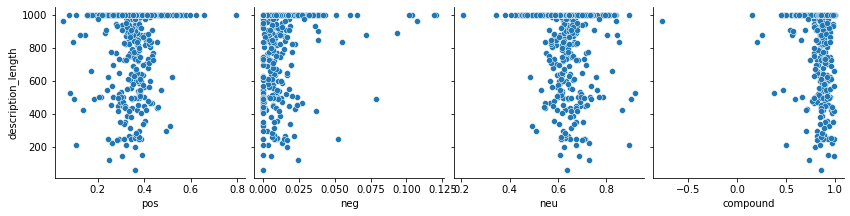

In [38]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['description_length'], 
             diag_kind = None, 
             height = 3);

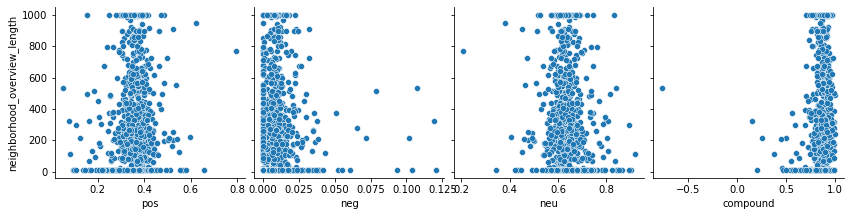

In [39]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['neighborhood_overview_length'], 
             diag_kind = None, 
             height = 3);

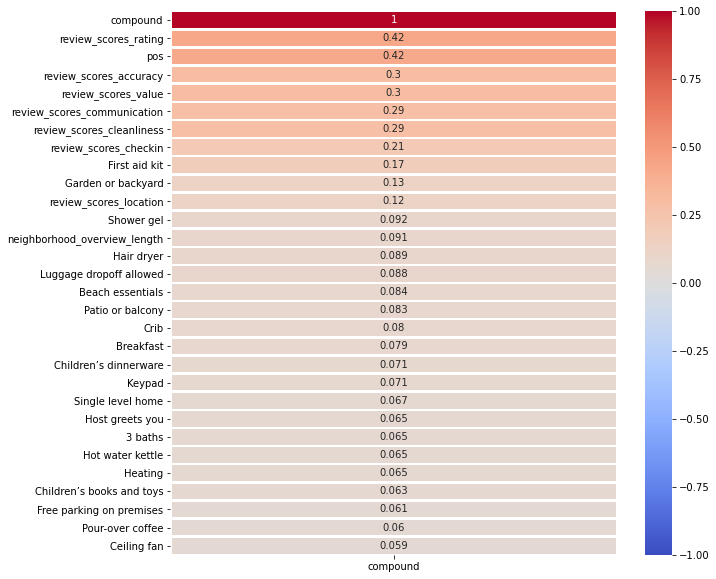

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['compound']].sort_values(by = ['compound'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

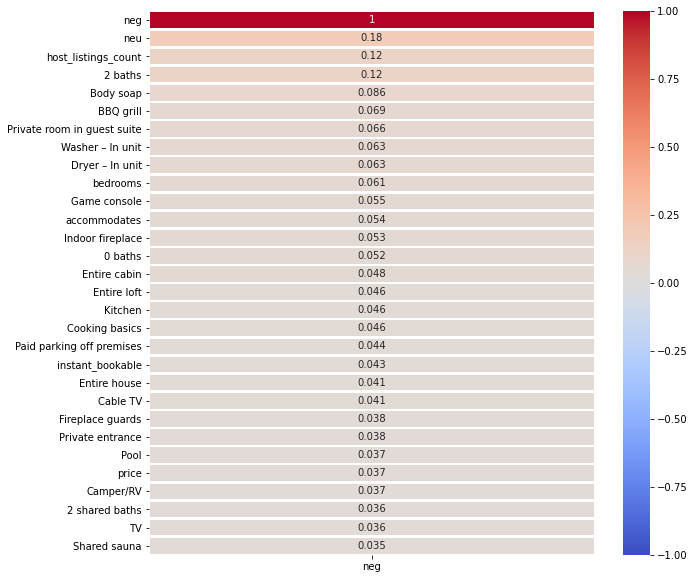

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['neg']].sort_values(by = ['neg'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

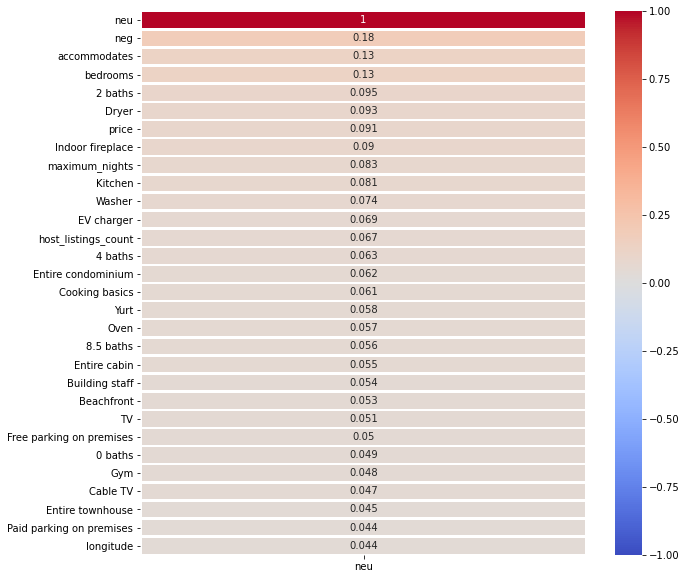

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['neu']].sort_values(by = ['neu'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

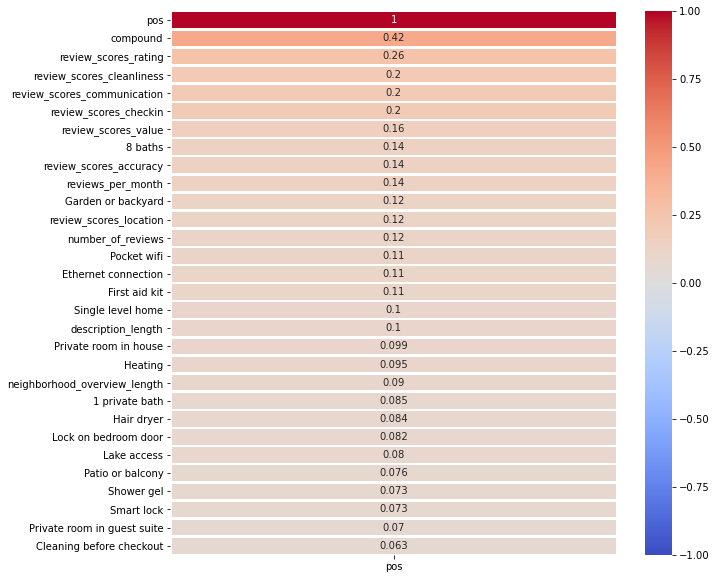

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['pos']].sort_values(by = ['pos'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

In [44]:
listing_reviews.sort_values(by = 'pos', ascending = False).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,2 burner induction stove top induction stove,"30"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Netflix","32"" TV with Amazon Prime Video, Netflix","40"" HDTV","42"" HDTV with Amazon Prime Video, Netflix, HBO Max","42"" HDTV with Netflix","46"" TV with Roku","48"" HDTV with standard cable","50"" HDTV","55"" HDTV with Netflix, HBO Max, Amazon Prime Video, Apple TV","55"" HDTV with premium cable, standard cable, Chromecast, Amazon Prime Video, Netflix, Roku",Air conditioning,Alaffia body soap,Alaffia conditioner,Alaffia shampoo,Alexa Bluetooth sound system,BBQ grill,Baby bath,Baby monitor,...,Private room in camper/rv,Private room in condominium,Private room in dome house,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in house,Private room in loft,Private room in nature lodge,Private room in resort,Private room in tent,Private room in tiny house,Private room in townhouse,Room in boutique hotel,Room in hotel,Shared room in house,Tent,Tiny house,Treehouse,Windmill,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,10 baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5.5 baths,6 baths,6.5 baths,8 baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath,pos,neu,neg,compound
112,4151679,Magnolia Garden Bungalow Dogs/Hot Tub,"The house is located walking distance to Capitola Village ( 5 min stroll),it has a fabulous beach and a large selection of places to eat and shop. Pleasure Point is also close with 38th ave Surf S...","Enjoy this lovely, tranquil neighborhood. A short stroll to amazing restaurants and local beaches. Close by is “The Surf Sanctuary” which is a wonderful walk way along the ocean, where people wal...",2014-01-12,"I've lived in Santa Cruz for about 35 years and still enjoy the beauty and variety of beaches, restaurants, and the ambiance of a resort town. I am an Animal Portrait Painter, gardener, and ride ...",within an hour,0.94,1,City of Capitola,36.96818,-121.96231,4,1.0,375,2,28,46,2014-12-22,2021-02-23,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.795000,0.205000,0.0,0.911800
279,12156358,2860 Modern Oasis,"Modern Oasis is a comfortably decorated, two-story home with vaulted ceilings and a beautifully landscaped yard.<br /><br /><b>The space</b><br />This Home is located in a safe, quiet, family fri...",No Content,2016-03-11,Kendall & Potter was established as a real estate company in (Phone number hidden by Airbnb) The brokers Skipper Kendall and William Pottermoved to Aptos to fulfill their dream of working in a sma...,within a day,0.78,38,City of Capitola,36.95904,-121.97653,6,2.0,450,2,180,3,2018-06-29,2020-08-14,100.0,10.0,10.0,10.0,10.0,10.0,9.0,0,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.658000,0.342000,0.0,0.827100
846,39558855,Main Beach 5000sf luxury-great 4 social distancing,"Ultimate vacation destination for your gathering- Luxurious home across from beach & wharf in the heart of Santa Cruz fun! You'll enjoy over 5,000 square feet of luxurious accommodations- 9 privat...","Your group can walk to just about everything, or just sit back and enjoy in this spectacular retreat. Located directly across the street from the beautiful Santa Cruz Wharf, famous Cow

In [45]:
listing_reviews.sort_values(by = 'neg', ascending = False).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,2 burner induction stove top induction stove,"30"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Netflix","32"" TV with Amazon Prime Video, Netflix","40"" HDTV","42"" HDTV with Amazon Prime Video, Netflix, HBO Max","42"" HDTV with Netflix","46"" TV with Roku","48"" HDTV with standard cable","50"" HDTV","55"" HDTV with Netflix, HBO Max, Amazon Prime Video, Apple TV","55"" HDTV with premium cable, standard cable, Chromecast, Amazon Prime Video, Netflix, Roku",Air conditioning,Alaffia body soap,Alaffia conditioner,Alaffia shampoo,Alexa Bluetooth sound system,BBQ grill,Baby bath,Baby monitor,...,Private room in camper/rv,Private room in condominium,Private room in dome house,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in house,Private room in loft,Private room in nature lodge,Private room in resort,Private room in tent,Private room in tiny house,Private room in townhouse,Room in boutique hotel,Room in hotel,Shared room in house,Tent,Tiny house,Treehouse,Windmill,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,10 baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5.5 baths,6 baths,6.5 baths,8 baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath,pos,neu,neg,compound
358,14965130,Concha Del Mar at Pleasure Point,"Come & enjoy this spacious one bedroom unit located in Pleasure Point, across the street from beach! The spacious floor plan offers a great layout for you to enjoy with friends. Sit in the living...",No Content,2015-12-10,"Located just across the street from Rio Del Mar Beach in Aptos, Bailey Property Management specializes in vacation homes throughout Santa Cruz County. From large spacious homes on West Cliff Dr ...",within a day,0.73,27,City of Capitola,36.95536,-121.97410,4,1.0,232,2,14,5,2017-06-20,2020-10-19,80.0,8.0,9.0,8.0,8.0,9.0,8.0,0,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2370,0.642333,0.120333,0.626467
711,31711091,Incredible Monterey Bay views 100,"Perfectly located in the community of Rio Del Mar, you can experience all that Monterey Bay has to offer in this completely remodeled one bedroom, one bath condo. The beautiful wrap around deck pr...","Just steps to some of Rio Del Mar’s local favorite restaurants: Cafe Rio and Pixie's Deli. Aptos Village is a short 5-minute drive and offers quaint shops, a variety of restaurants, plus 30 miles...",2016-06-15,No Content,within a few hours,0.73,31,Unincorporated Areas,36.96920,-121.90543,4,1.0,249,3,20,6,2019-06-25,2020-09-20,93.0,10.0,10.0,10.0,10.0,10.0,9.0,0,0.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0760,0.804667,0.119333,0.147200
837,39132034,A Nest at the Beach!,This Original Seabright Beach single story cottage was converted in the early 1900's to a two story Craftsman Bungalow. The home is furnished with nautical decor. Wake up each morning to the gentl...,"The beach neighborhood is normally quiet, with foot traffic to and from the beach. The harbor is a couple blocks away, During the Summer months there is a free shuttle at the harbor to get you and...",2016-07-03,No Content,within an hour,0.98,0,City of Santa Cruz,36.96569,-122.00645,10,5.0,575,2,1125,20,2019-10-27,2021-02-15,92.0,9.0,10.0,10.0,10.0,10.0,9.0,1,1.22,0,0,0,0,0,0,0,0,0,0,0,

In [46]:
listing_reviews.sort_values(by = 'compound', ascending = False).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,2 burner induction stove top induction stove,"30"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Netflix","32"" TV with Amazon Prime Video, Netflix","40"" HDTV","42"" HDTV with Amazon Prime Video, Netflix, HBO Max","42"" HDTV with Netflix","46"" TV with Roku","48"" HDTV with standard cable","50"" HDTV","55"" HDTV with Netflix, HBO Max, Amazon Prime Video, Apple TV","55"" HDTV with premium cable, standard cable, Chromecast, Amazon Prime Video, Netflix, Roku",Air conditioning,Alaffia body soap,Alaffia conditioner,Alaffia shampoo,Alexa Bluetooth sound system,BBQ grill,Baby bath,Baby monitor,...,Private room in camper/rv,Private room in condominium,Private room in dome house,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in house,Private room in loft,Private room in nature lodge,Private room in resort,Private room in tent,Private room in tiny house,Private room in townhouse,Room in boutique hotel,Room in hotel,Shared room in house,Tent,Tiny house,Treehouse,Windmill,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,10 baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5.5 baths,6 baths,6.5 baths,8 baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath,pos,neu,neg,compound
687,29638378,Paradise Cabin Nestled Among the Redwoods,"What is paradise? If your idea of perfection is peace and quiet, beautiful redwoods towering around you and the open sky above, blue and beautiful by day, ink black speckled with more stars than y...","This is a magical place where the hundred-plus year old redwoods tower above you, yet leave the sky open directly above to let in the su during the day and reveal the stars at night. The air is c...",2016-04-04,"I like to think I'm not your usual Silicon Valley tech guy. I've lived in Europe and Japan, and enjoy travel whenever I can. I love to meet new folks and make friends as I go.\r\n\r\nMy travel sty...",within an hour,0.87,1,Unincorporated Areas,37.13613,-122.13004,5,1.0,250,2,30,10,2018-12-23,2021-02-22,98.0,10.0,9.0,10.0,10.0,10.0,9.0,1,0.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2540,0.7380,0.0090,0.99590
826,38187802,"♛ 5,700 sq. Luxury Villa, Oceanview, Infinity Pool","**Vacation rental only. No weddings or events**<br /><br />Rustic Mediterranean style villa with modern influences. Meticulous attention to detail is apparent throughout this home, making it an ex...","Perched on a hillside, this large and private lot is situated on a quiet country road yet just 7 mins from shops, restaurants and 15 mins from beach! You have incredible 180 degree views of Monter...",2011-04-08,"Hi, I'm Jay, an Airbnb user since 2011. I've been fortunate enough to host amazing travelers for the past nine years while exploring over 90 countries on all continents myself. \n\nI feel strongl...",within a few hours,0.60,0,Unincorporated Areas,37.01608,-121.97142,10,5.0,1438,2,1125,11,2019-11-30,2021-02-19,100.0,10.0,10.0,10.0,10.0,10.0,9.0,0,0.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.3200,0.6720,0.0080,0.99500
743,33530670,"Sweeping Ocean Views for 12, Steps to the beach","Perfect for families looking for a beach getaway, staycation or social distancing. Enjoy panoramic ocean views and listen to the sound of the w

In [47]:
listing_reviews.sort_values(by = 'compound', ascending = True).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,2 burner induction stove top induction stove,"30"" HDTV","32"" HDTV","32"" HDTV with Amazon Prime Video, Netflix","32"" TV with Amazon Prime Video, Netflix","40"" HDTV","42"" HDTV with Amazon Prime Video, Netflix, HBO Max","42"" HDTV with Netflix","46"" TV with Roku","48"" HDTV with standard cable","50"" HDTV","55"" HDTV with Netflix, HBO Max, Amazon Prime Video, Apple TV","55"" HDTV with premium cable, standard cable, Chromecast, Amazon Prime Video, Netflix, Roku",Air conditioning,Alaffia body soap,Alaffia conditioner,Alaffia shampoo,Alexa Bluetooth sound system,BBQ grill,Baby bath,Baby monitor,...,Private room in camper/rv,Private room in condominium,Private room in dome house,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in house,Private room in loft,Private room in nature lodge,Private room in resort,Private room in tent,Private room in tiny house,Private room in townhouse,Room in boutique hotel,Room in hotel,Shared room in house,Tent,Tiny house,Treehouse,Windmill,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,10 baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4 shared baths,4.5 baths,5.5 baths,6 baths,6.5 baths,8 baths,8.5 baths,Half-bath,Private half-bath,Shared half-bath,pos,neu,neg,compound
837,39132034,A Nest at the Beach!,This Original Seabright Beach single story cottage was converted in the early 1900's to a two story Craftsman Bungalow. The home is furnished with nautical decor. Wake up each morning to the gentl...,"The beach neighborhood is normally quiet, with foot traffic to and from the beach. The harbor is a couple blocks away, During the Summer months there is a free shuttle at the harbor to get you and...",2016-07-03,No Content,within an hour,0.98,0,City of Santa Cruz,36.96569,-122.00645,10,5.0,575,2,1125,20,2019-10-27,2021-02-15,92.0,9.0,10.0,10.0,10.0,10.0,9.0,1,1.22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05200,0.841000,0.107000,-0.76910
711,31711091,Incredible Monterey Bay views 100,"Perfectly located in the community of Rio Del Mar, you can experience all that Monterey Bay has to offer in this completely remodeled one bedroom, one bath condo. The beautiful wrap around deck pr...","Just steps to some of Rio Del Mar’s local favorite restaurants: Cafe Rio and Pixie's Deli. Aptos Village is a short 5-minute drive and offers quaint shops, a variety of restaurants, plus 30 miles...",2016-06-15,No Content,within a few hours,0.73,31,Unincorporated Areas,36.96920,-121.90543,4,1.0,249,3,20,6,2019-06-25,2020-09-20,93.0,10.0,10.0,10.0,10.0,10.0,9.0,0,0.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07600,0.804667,0.119333,0.14720
526,22354883,Beach home next to Hidden Beach in Rio Del Mar,"Hidden Beach Getaway!<br /><br />Located in Aptos, this spacious, well-maintained 3 bedrooms 2 bathrooms home has a wonderful Ocean View from the living room. The large sunny deck is on the top le...",No Content,2015-12-10,"Located just across the street from Rio Del Mar Beach in Aptos, Bailey Property Management specializes in vacation homes throughout Santa Cruz County. From large spacious homes on West Cliff Dr ...",within a day,0.73,27,Unincorporated Areas,36.96235,-121.88951,7,3.0,315,2,14,7,2018-02-19,2020-08-16,71.0,7.0,7.0,8.0,8.0,8.0,7.0,0,0.19,0,

## TF-IDF

Splitting up the dataframe into 3 separate dataframes in order to be able to see what words are popping up in negative reviews, positive reviews, and neutral reviews.

In [48]:
reviews_neu = reviews[(reviews['neu'] == 1.000) | (reviews['neg'] == reviews['pos'])]
reviews_pos = reviews[reviews['pos'] > reviews['neg']]
reviews_neg = reviews[reviews['neg'] > reviews['pos']]


print(f'Neutral Reviews: {reviews_neu.shape}')
print(f'Positive Reviews: {reviews_pos.shape}')
print(f'Negative Reviews: {reviews_neg.shape}')

Neutral Reviews: (262, 6)
Positive Reviews: (30872, 6)
Negative Reviews: (235, 6)


Adding stop words that proved to be frequent words but showed no value.

In [49]:
words = ['santa', 'cruz' 'didn', 'definitely', 'check', 'bnb', 'air', 've', 'did', 'needed', 'was', 'wa', 'airbnb', 'minute', 'place', 
         'stay', 'great', 'space', 'apartment', 'super', 'home']

stop_words = text.ENGLISH_STOP_WORDS.union(words)

In [50]:
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 4000)

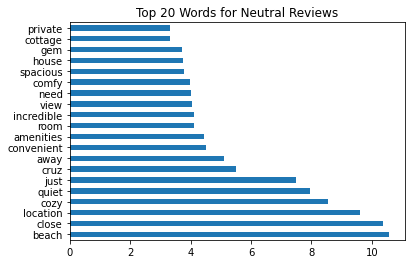

In [51]:
X_tvec_neu = tvec.fit_transform(reviews_neu['comment'])

df_X_neu = pd.DataFrame(X_tvec_neu.todense(), columns = tvec.get_feature_names())

df_X_neu.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Neutral Reviews');

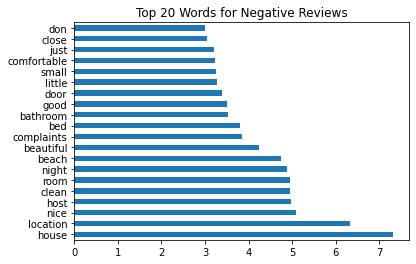

In [52]:
X_tvec_neg = tvec.fit_transform(reviews_neg['comment'])

df_X_neg = pd.DataFrame(X_tvec_neg.todense(), columns = tvec.get_feature_names())

df_X_neg.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Negative Reviews');

In [53]:
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 4000, min_df = 0.001)

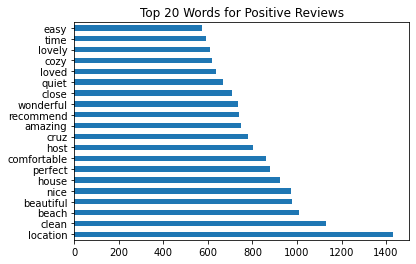

In [54]:
X_tvec_pos = tvec.fit_transform(reviews_pos['comment'])

df_X_pos = pd.DataFrame(X_tvec_pos.todense(), columns = tvec.get_feature_names())

df_X_pos.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Positive Reviews');

#### Bigrams

In [55]:
tvec_2 = TfidfVectorizer(stop_words = stop_words, ngram_range = (2,2))

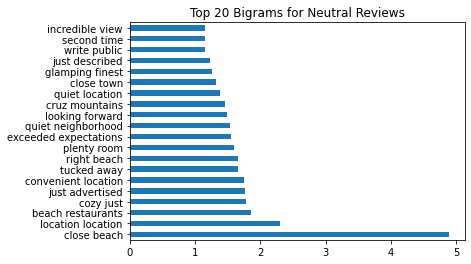

In [56]:
X_2_tvec_neu = tvec_2.fit_transform(reviews_neu['comment'])

df_X_2_neu = pd.DataFrame(X_2_tvec_neu.todense(), columns = tvec_2.get_feature_names())

df_X_2_neu.sum().sort_values(ascending = False).head(20).plot(kind='barh')
plt.title('Top 20 Bigrams for Neutral Reviews');

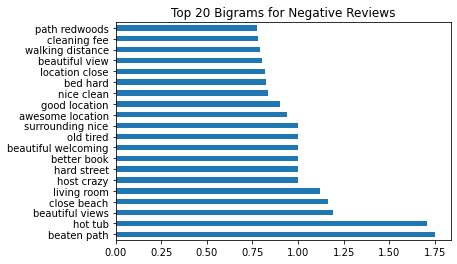

In [57]:
X_2_tvec_neg = tvec_2.fit_transform(reviews_neg['comment'])

df_X_2_neg = pd.DataFrame(X_2_tvec_neg.todense(), columns = tvec_2.get_feature_names())

df_X_2_neg.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Bigrams for Negative Reviews');

In [58]:
tvec_2_pos = TfidfVectorizer(stop_words = stop_words, ngram_range = (2,2), min_df = 0.001)

In [59]:
X_2_tvec_pos = tvec_2_pos.fit_transform(reviews_pos['comment'])

In [60]:
df_X_2_pos = pd.DataFrame(X_2_tvec_pos.todense(), columns = tvec_2_pos.get_feature_names())

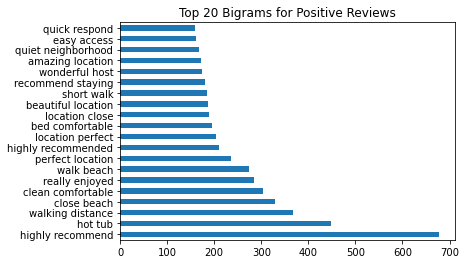

In [61]:
df_X_2_pos.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Top 20 Bigrams for Positive Reviews');

Creating a df for all rows tvec

In [62]:
tvec_reviews = tvec.fit_transform(reviews['comment'])

tvec_reviews_df = pd.DataFrame(tvec_reviews.todense(), columns = tvec.get_feature_names())

Adding back the 'id'column

In [63]:
tvec_reviews_df['id'] = review['listing_id']

In [64]:
tvec_reviews_df = tvec_reviews_df.groupby('id', as_index=False).mean()

In [65]:
listing_tvec_reviews = listing.merge(tvec_reviews_df, on = 'id')

In [66]:
listing_tvec_reviews.shape

(858, 2169)

In [67]:
# Source: https://towardsdatascience.com/using-ml-for-holiday-planning-summarising-airbnb-reviews-193abb002232

import operator

def print_top_tokens(feature_names, word_counts, n_top = 20): 
    tdidf_counts = zip(feature_names, word_counts.sum(axis = 0).tolist()[0])
    sorted_x = sorted(dict(tdidf_counts).items(), key = operator.itemgetter(1), reverse = True)

    if n_top:
        return sorted_x[: n_top]
    else:
        return sorted_x
    
feature_names = tvec.get_feature_names()
print_top_tokens(feature_names, tvec_reviews)

[('location', 1448.65994513288),
 ('clean', 1139.403384890739),
 ('beach', 1024.621670429917),
 ('beautiful', 986.8977830320558),
 ('nice', 982.1768811460689),
 ('house', 935.6659573663472),
 ('perfect', 883.8342177954445),
 ('comfortable', 865.1027399858393),
 ('host', 808.6338672496765),
 ('cruz', 786.649972832896),
 ('amazing', 752.7531252842753),
 ('recommend', 742.2869246414327),
 ('wonderful', 739.6099756283146),
 ('close', 720.191283012399),
 ('quiet', 679.9735552148406),
 ('loved', 638.0230502934717),
 ('cozy', 628.8456063920111),
 ('lovely', 614.0020451738224),
 ('time', 594.6492198177363),
 ('easy', 577.7102078627174)]

## LDA 

the lemmatized text will be vectorized using a TF-IDF vectorizer and converted to a term document matrix that is compatible with the Gensim NLP library.



In [68]:
# Tokenization: 
#     Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

reviews['review_tokens'] = reviews.apply(lambda row: word_tokenize(row['comment']), axis = 1)

In [69]:
# Words are lemmatized:
#     words in third person are changed to first person and verbs in past and future tenses are changed into present.
# Lemmatizing and stemming are two forms of shortening words so we can combine similar forms of the same word.
# When we "lemmatize" data, we take words and attempt to return their lemma, or the base/dictionary form of a word.

def lemmatize_text(review):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in review]

reviews['review_lemmatized'] = reviews['review_tokens'].apply(lemmatize_text)
reviews['review_lemmatized'] = reviews['review_lemmatized'].str.join(' ')

In [70]:
tvec = TfidfVectorizer(stop_words = stop_words, min_df = 0.001, ngram_range = (1,2))

tvec_reviews = tvec.fit_transform(reviews['review_lemmatized'])    #Sparce Matrix

In [71]:
tvec_t = tvec_reviews.transpose() # transpose document-term matrix -> to convert it to a term-document matrix

# # Convert to Gensim Corpus
# #     Gensim requires the format of the input to be a Gensim corpus data type

sparse = scipy.sparse.csr_matrix(tvec_t)

corpus = matutils.Sparse2Corpus(tvec_t)

In [72]:
dictionary = dict((v,k) for k,v in tvec.vocabulary_.items())

gensim_dict = Dictionary.from_corpus(corpus = corpus, id2word = dictionary)

In [73]:
lda = LdaModel(corpus = corpus, 
               num_topics = 5, 
               id2word = dictionary, 
               passes = 60, 
               decay = 0.8,           
               offset = 10,           
               random_state = 49)

In [74]:
coherence = CoherenceModel(model = lda,
                           corpus = corpus,
                           dictionary = dictionary,
                           coherence = 'u_mass')       

print(round(coherence.get_coherence(), 3))

-2.225


In [75]:
prep = pyLDAvis.gensim.prepare(lda, corpus, gensim_dict)

pyLDAvis.display(prep)

Recommendations based off information below...
0. Location is very important. In many positive reviews mentioning the location of the Airbnb, the guests are mentioning "easy" "walk" "restaurant" "downtown" and "walking distance". So for those Airbnb's that are not in the city center, it is key to mention what is walkable from your property so the guest is aware that they have that option.

1. In posts mentioning the property itself, the bathroom and the kitchen are very frequently mentioned 

In [76]:
lda.print_topics(num_topics = 10, num_words = 12)

[(0,
  '0.016*"location" + 0.015*"perfect" + 0.014*"cruz" + 0.013*"beach" + 0.012*"clean" + 0.010*"easy" + 0.010*"recommend" + 0.009*"quick" + 0.009*"highly" + 0.009*"host" + 0.008*"walk" + 0.007*"close"'),
 (1,
  '0.019*"host" + 0.009*"wonderful" + 0.009*"amazing" + 0.008*"friendly" + 0.008*"beautiful" + 0.007*"recommend" + 0.007*"touch" + 0.007*"lovely" + 0.007*"comfortable" + 0.007*"thoughtful" + 0.006*"welcoming" + 0.006*"location"'),
 (2,
  '0.016*"beautiful" + 0.012*"view" + 0.011*"redwood" + 0.010*"cabin" + 0.010*"peaceful" + 0.009*"amazing" + 0.009*"away" + 0.008*"loved" + 0.007*"relaxing" + 0.007*"tree" + 0.007*"quiet" + 0.007*"perfect"'),
 (3,
  '0.007*"beach" + 0.007*"kitchen" + 0.007*"house" + 0.006*"bed" + 0.005*"nice" + 0.005*"room" + 0.005*"comfortable" + 0.004*"just" + 0.004*"clean" + 0.004*"ha" + 0.004*"family" + 0.004*"location"'),
 (4,
  '0.028*"nice" + 0.025*"location" + 0.019*"clean" + 0.018*"close" + 0.018*"beach" + 0.016*"distance" + 0.016*"walking" + 0.015*"walk